In [22]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import networkx as nx
from shapely.ops import polygonize, linemerge, unary_union
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from scipy.spatial import ConvexHull
import math
import random
from matplotlib.patches import Circle
import matplotlib.colors as mcolors

Step 1: Load the street network shapefile

In [23]:
street_network = gpd.read_file('Streets.shp')

Step 2: Check the CRS (Coordinate Reference System)

In [24]:
print("Original CRS:", street_network.crs)

Original CRS: EPSG:4326


Step 3: Convert to a projected CRS if needed (for accurate distance measurements)

In [25]:
projected_crs = "EPSG:3857"  # Web Mercator - adjust as needed
street_network = street_network.to_crs(projected_crs)

Step 4: Explore basic information

In [26]:
print("\nDataset Basic Information:")
print(f"Number of street segments: {len(street_network)}")
print("\nGeometry types:")
print(street_network.geometry.type.value_counts())
print("\nAttribute columns:")
print(street_network.columns)


Dataset Basic Information:
Number of street segments: 494821

Geometry types:
LineString    494821
Name: count, dtype: int64

Attribute columns:
Index(['OBJECTID', 'LINK_ID', 'ST_NAME', 'geometry'], dtype='object')


Step 5: Examine attribute information

In [27]:
print("\nSample of attribute data:")
print(street_network.head())


Sample of attribute data:
   OBJECTID      LINK_ID              ST_NAME  \
0         1  590186215.0       Rīga-Stockholm   
1         2  749463153.0  Ventspils-Nynäshamn   
2         3  750303390.0           Rīgas iela   
3         4  750303392.0           Brūža iela   
4         5  750303393.0       Tālavijas iela   

                                            geometry  
0  LINESTRING (2674422.936 7772848.595, 2672650.7...  
1  LINESTRING (2398254.865 7841417.703, 2397160.5...  
2  LINESTRING (2927674.778 7753932.22, 2927611.32...  
3  LINESTRING (3011224.509 7847750.359, 3011218.9...  
4  LINESTRING (3086551.068 7667768.488, 3086525.4...  


Step 6: Point sampling approach with multiple clustering algorithms

In [28]:
print("\nExecuting advanced point-based clustering for roundabout detection...")


Executing advanced point-based clustering for roundabout detection...


Constants for the algorithm (stricter parameters)

In [29]:
SAMPLING_DISTANCE = 0.5  # Sample a point every 0.5 meters
DBSCAN_EPS = 8  # Maximum distance between points in a cluster (in meters)
DBSCAN_MIN_SAMPLES = 15  # Increased from 10 to be more selective
MIN_ROUNDABOUT_RADIUS = 5  # Increased from 4 to filter out smaller circles
MAX_ROUNDABOUT_RADIUS = 30  # Decreased from 50 to be more selective
MIN_CIRCULARITY = 0.75  # Increased from 0.65 for stricter circle detection
MIN_POINTS_IN_CLUSTER = 40  # Increased from 30 to require more evidence
MAX_POINTS_FOR_PROCESSING = 200000  # Limit total points for performance

In [30]:
def resample_line_at_distance(line, distance):
    """Resample a LineString with points at regular distance intervals."""
    resampled_points = []
    line_length = line.length
    
    # Return original vertices if line is too short
    if line_length < distance:
        return [Point(xy) for xy in line.coords]
    
    # Calculate number of points to sample
    num_points = int(line_length / distance)
    
    # Interpolate points along line
    for i in range(num_points + 1):
        # Get point at specified distance along the line
        position = i * distance
        if position > line_length:
            position = line_length
        point = line.interpolate(position)
        resampled_points.append(point)
    
    return resampled_points

Function to analyze road intersection angles

In [31]:
def analyze_intersection_angles(points, centroid, num_sectors=16):
    """Analyze if roads form approximate 90-degree intersections."""
    # Divide the area around centroid into sectors and count points
    sectors = [0] * num_sectors
    for p in points:
        dx = p[0] - centroid.x
        dy = p[1] - centroid.y
        angle = (math.degrees(math.atan2(dy, dx)) + 360) % 360
        sector_idx = int(angle / (360/num_sectors))
        sectors[sector_idx] += 1
    
    # Calculate sector coverage
    significant_threshold = max(3, 0.03 * len(points))
    active_sectors = [i for i, count in enumerate(sectors) if count >= significant_threshold]
    
    # Look for 90-degree patterns (sectors approximately 90 degrees apart)
    has_perpendicular_roads = False
    if len(active_sectors) >= 4:  # Need at least 4 active sectors
        for i in active_sectors:
            # Check if there's an active sector approximately 90 degrees away
            potential_perpendicular = [(i + int(num_sectors/4)) % num_sectors, 
                                      (i - int(num_sectors/4)) % num_sectors]
            if any(p in active_sectors for p in potential_perpendicular):
                has_perpendicular_roads = True
                break
    
    return has_perpendicular_roads, active_sectors, sectors

Function to divide the map into smaller sections

In [32]:
def create_map_sections(gdf, num_sections=4):
    """Divide the map into smaller rectangular sections."""
    bounds = gdf.total_bounds  # (minx, miny, maxx, maxy)
    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]
    
    # Create grid cells
    cells = []
    for i in range(num_sections):
        for j in range(num_sections):
            minx = bounds[0] + i * width/num_sections
            maxx = bounds[0] + (i+1) * width/num_sections
            miny = bounds[1] + j * height/num_sections
            maxy = bounds[1] + (j+1) * height/num_sections
            cells.append((minx, miny, maxx, maxy))
    
    return cells

Extract sample points along all street segments

In [33]:
print("Resampling street segments into points...")
all_sampled_points = []
segment_count = len(street_network)

Resampling street segments into points...


Process in batches for performance

In [34]:
batch_size = 1000
num_batches = (segment_count + batch_size - 1) // batch_size
total_points = 0

In [35]:
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, segment_count)
    
    print(f"Processing batch {batch_idx+1}/{num_batches} (segments {start_idx}-{end_idx})")
    
    batch_points = []
    for _, row in street_network.iloc[start_idx:end_idx].iterrows():
        if row.geometry.geom_type == 'LineString':
            points = resample_line_at_distance(row.geometry, SAMPLING_DISTANCE)
            batch_points.extend(points)
        elif row.geometry.geom_type == 'MultiLineString':
            for line in row.geometry.geoms:
                points = resample_line_at_distance(line, SAMPLING_DISTANCE)
                batch_points.extend(points)
                
    all_sampled_points.extend(batch_points)
    total_points += len(batch_points)
    
    # Safety check to avoid memory issues
    if total_points > MAX_POINTS_FOR_PROCESSING:
        print(f"Warning: Reached {total_points} points. Sampling {MAX_POINTS_FOR_PROCESSING} randomly.")
        all_sampled_points = random.sample(all_sampled_points, MAX_POINTS_FOR_PROCESSING)
        break

Processing batch 1/495 (segments 0-1000)


In [36]:
print(f"Generated {len(all_sampled_points)} sample points")

Generated 200000 sample points


Convert sampled points to coordinates for clustering

In [37]:
point_coords = np.array([[p.x, p.y] for p in all_sampled_points])

Create map sections for targeted analysis

In [38]:
map_sections = create_map_sections(street_network, num_sections=2)  # Start with 4 sections (2Ã—2 grid)

Prepare to store final roundabout candidates

In [39]:
final_roundabouts = []

Process each map section separately


Processing map section 1/4
  Section contains 16264 points
  Applying DBSCAN clustering...
  DBSCAN found 0 clusters
  Applying KMeans clustering...
  KMeans with 5 clusters applied
  Applying Agglomerative clustering...
  Section too large for Agglomerative clustering (16264 points).
  Randomly sampling 5000 points for hierarchical clustering.


d:\HERE\Actual\venv\Lib\site-packages\sklearn\cluster\_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 57 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


  Agglomerative clustering with 5 clusters applied

  Analyzing DBSCAN clusters for roundabout patterns...

  Analyzing KMeans clusters for roundabout patterns...

  Analyzing Agglomerative clusters for roundabout patterns...
  Found 0 potential roundabouts in section 1

Processing map section 2/4
  Section contains 80190 points
  Applying DBSCAN clustering...
  DBSCAN found 0 clusters
  Applying KMeans clustering...
  KMeans with 5 clusters applied
  Applying Agglomerative clustering...
  Section too large for Agglomerative clustering (80190 points).
  Randomly sampling 5000 points for hierarchical clustering.


d:\HERE\Actual\venv\Lib\site-packages\sklearn\cluster\_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


  Agglomerative clustering with 5 clusters applied

  Analyzing DBSCAN clusters for roundabout patterns...

  Analyzing KMeans clusters for roundabout patterns...

  Analyzing Agglomerative clusters for roundabout patterns...
  Found 0 potential roundabouts in section 2

Processing map section 3/4
  Section contains 52191 points
  Applying DBSCAN clustering...
  DBSCAN found 0 clusters
  Applying KMeans clustering...
  KMeans with 5 clusters applied
  Applying Agglomerative clustering...
  Section too large for Agglomerative clustering (52191 points).
  Randomly sampling 5000 points for hierarchical clustering.


d:\HERE\Actual\venv\Lib\site-packages\sklearn\cluster\_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 19 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


  Agglomerative clustering with 5 clusters applied

  Analyzing DBSCAN clusters for roundabout patterns...

  Analyzing KMeans clusters for roundabout patterns...

  Analyzing Agglomerative clusters for roundabout patterns...
  Found 0 potential roundabouts in section 3

Processing map section 4/4
  Section contains 51355 points
  Applying DBSCAN clustering...
  DBSCAN found 0 clusters
  Applying KMeans clustering...
  KMeans with 5 clusters applied
  Applying Agglomerative clustering...
  Section too large for Agglomerative clustering (51355 points).
  Randomly sampling 5000 points for hierarchical clustering.


d:\HERE\Actual\venv\Lib\site-packages\sklearn\cluster\_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 17 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


  Agglomerative clustering with 5 clusters applied

  Analyzing DBSCAN clusters for roundabout patterns...

  Analyzing KMeans clusters for roundabout patterns...

  Analyzing Agglomerative clusters for roundabout patterns...
  Found 0 potential roundabouts in section 4


<Figure size 1000x600 with 0 Axes>

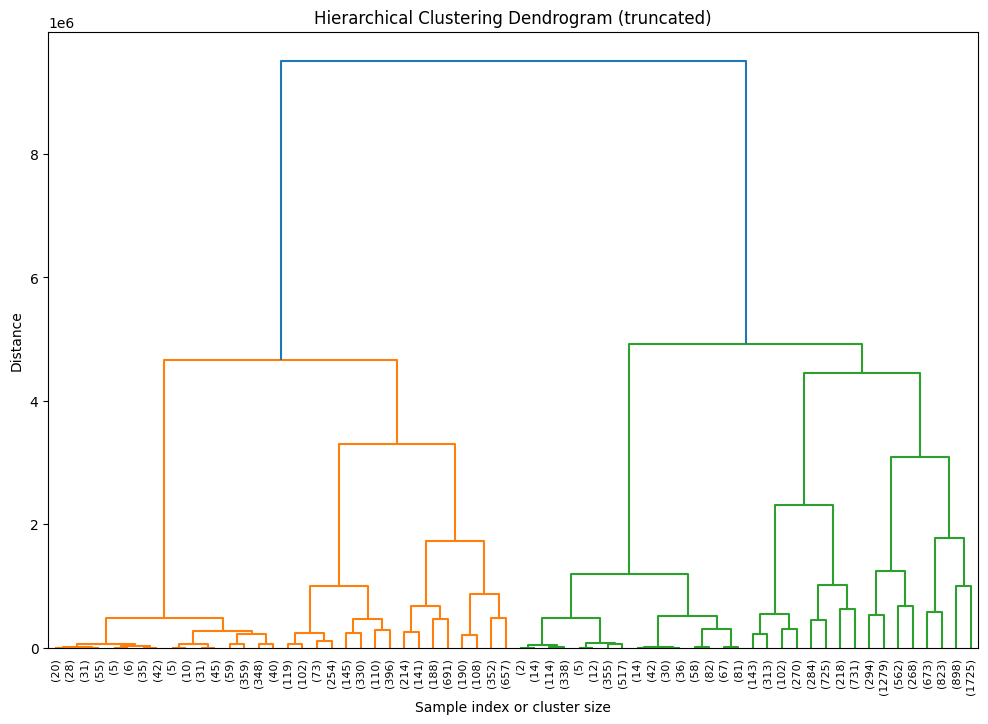

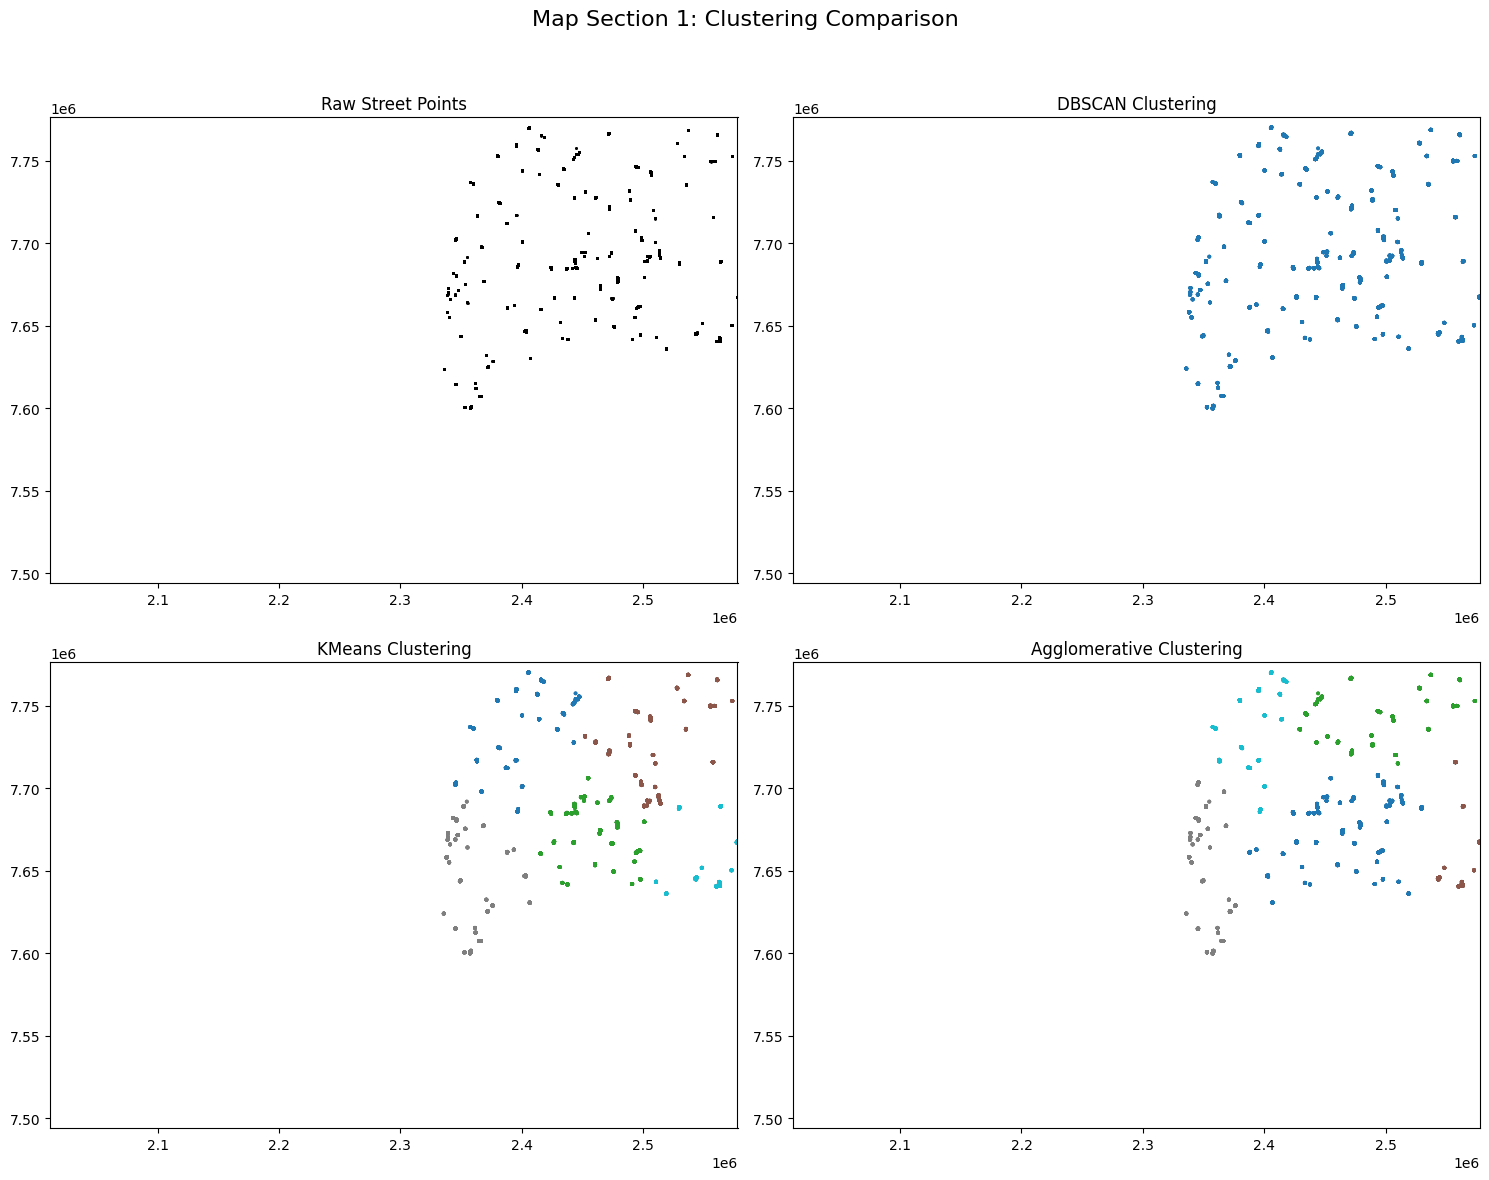

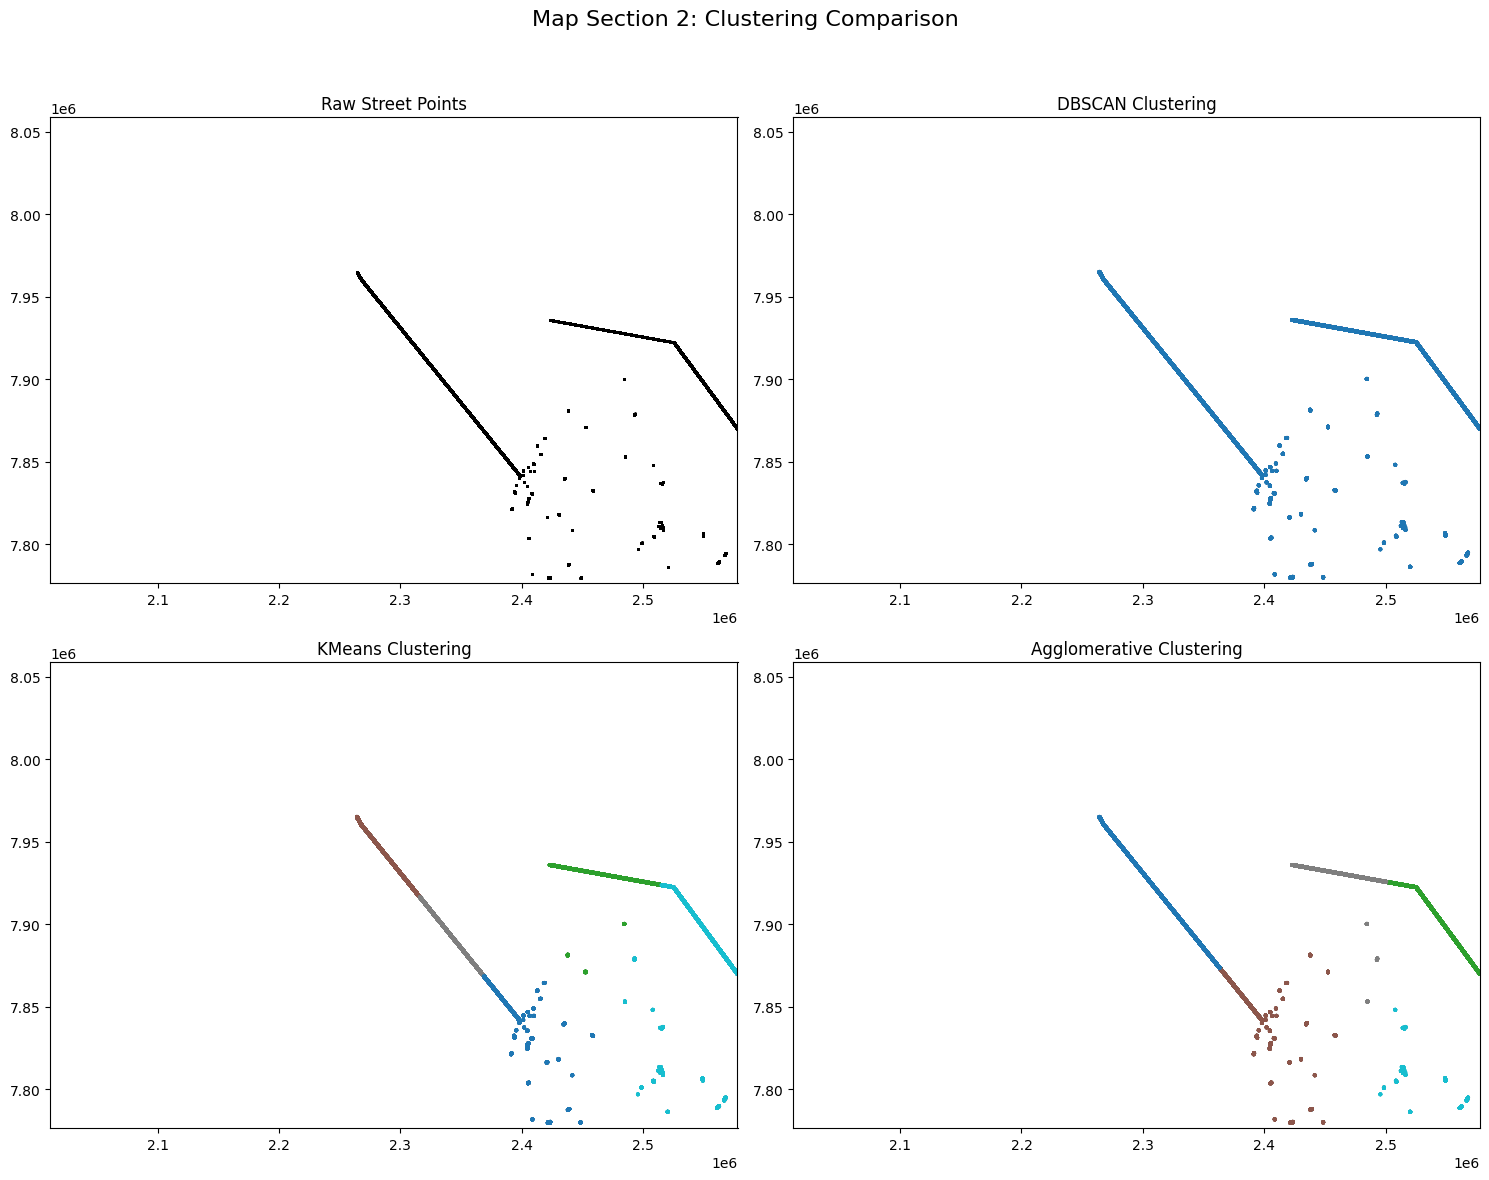

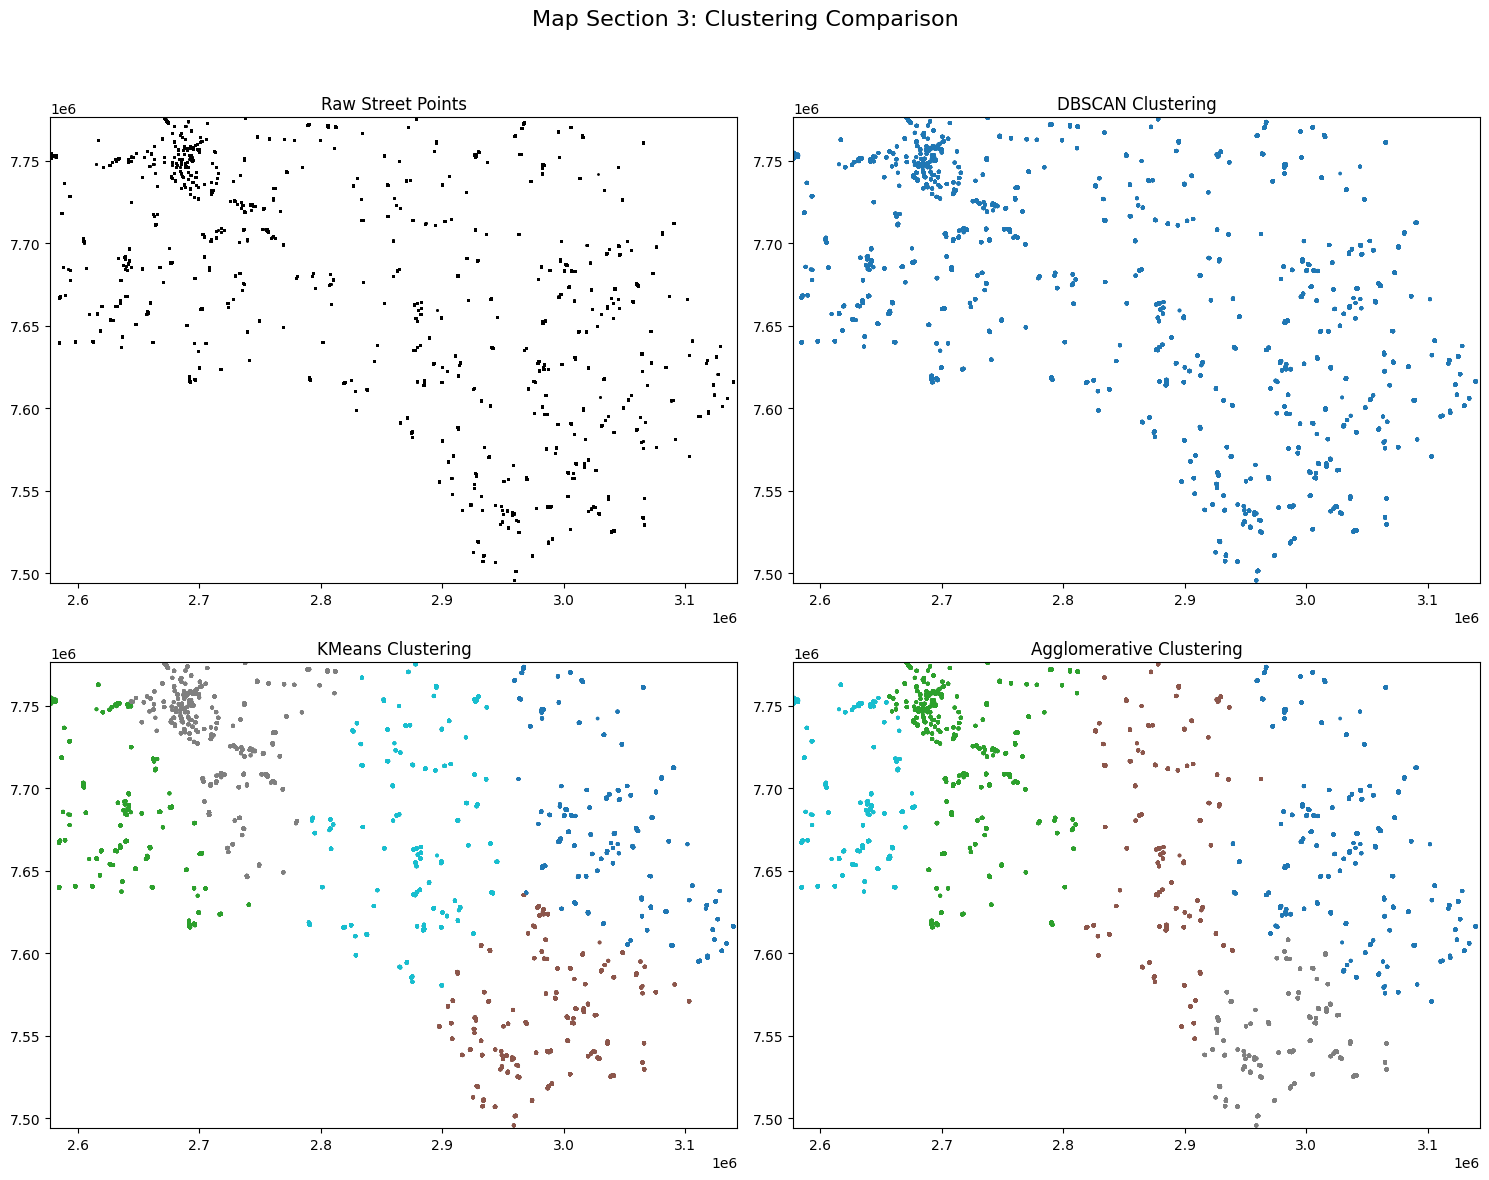

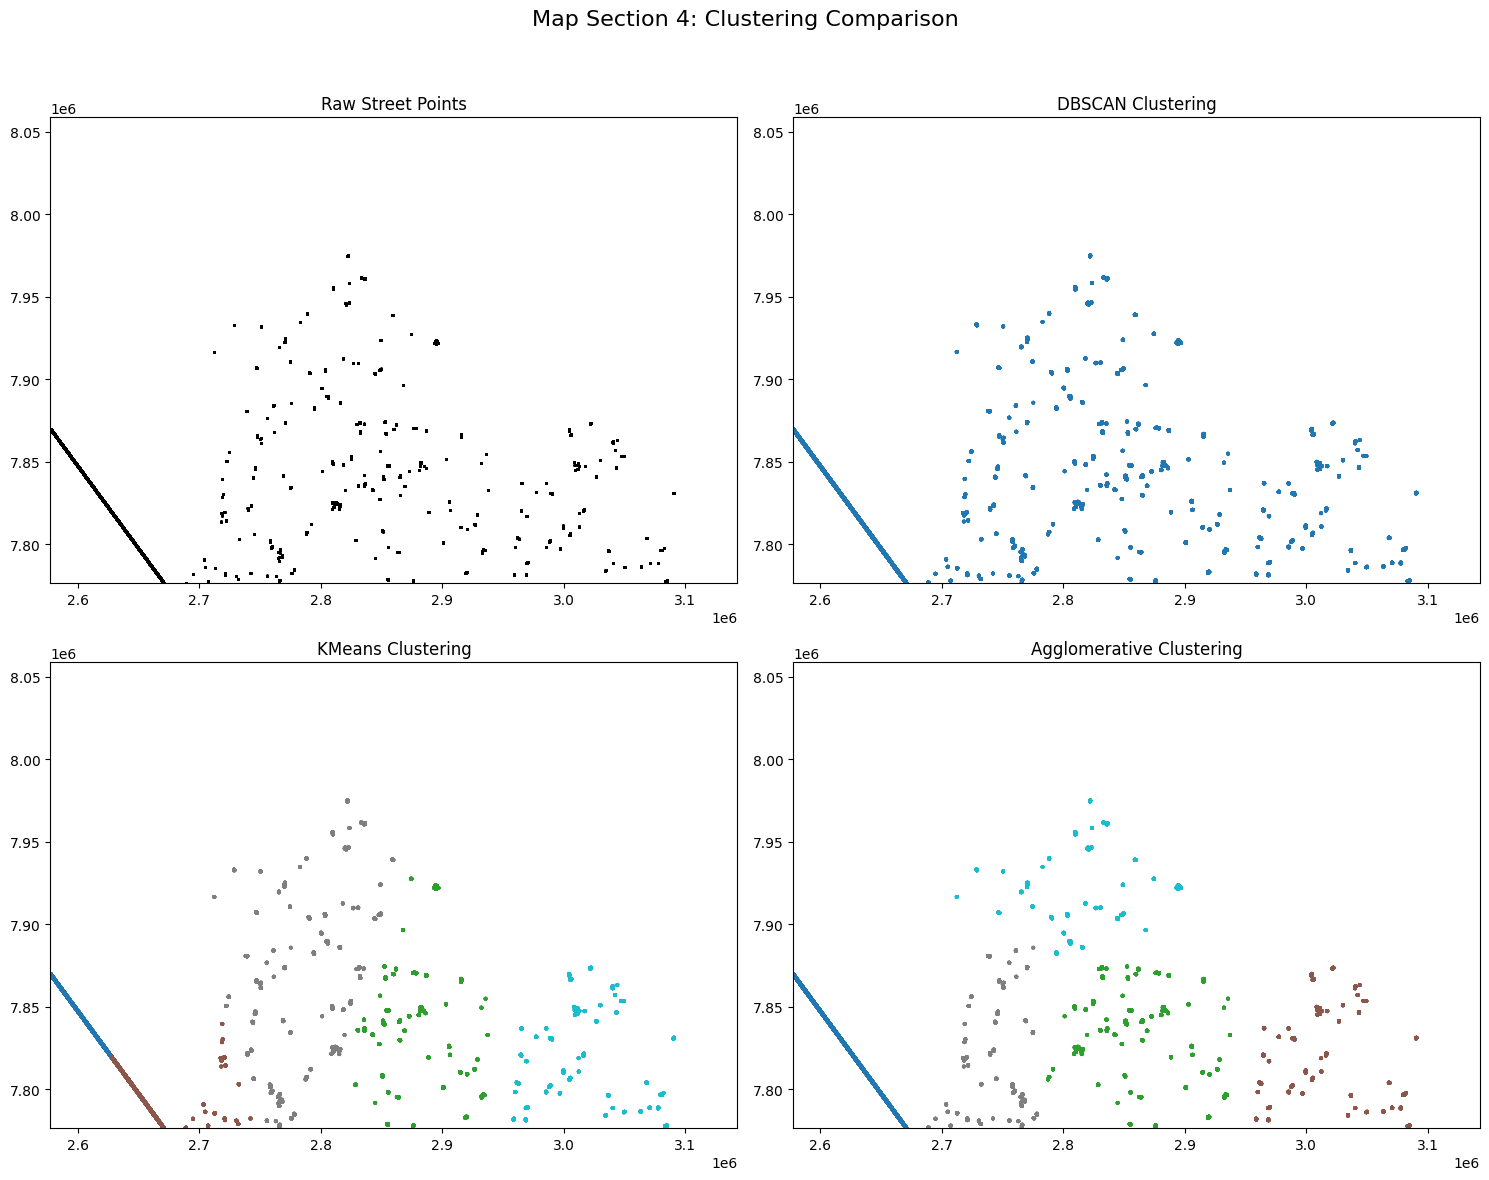

In [40]:
for section_idx, section in enumerate(map_sections):
    minx, miny, maxx, maxy = section
    print(f"\nProcessing map section {section_idx+1}/{len(map_sections)}")
    
    # Filter points within this section
    section_mask = ((point_coords[:, 0] >= minx) & (point_coords[:, 0] <= maxx) &
                    (point_coords[:, 1] >= miny) & (point_coords[:, 1] <= maxy))
    section_points = point_coords[section_mask]
    
    if len(section_points) < 100:
        print(f"  Too few points in section {section_idx+1}, skipping")
        continue
        
    print(f"  Section contains {len(section_points)} points")
    
    # Apply multiple clustering algorithms to this section
    clustering_results = []
    
    # 1. DBSCAN clustering
    print("  Applying DBSCAN clustering...")
    dbscan = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES, algorithm='ball_tree', n_jobs=-1)
    dbscan_labels = dbscan.fit_predict(section_points)
    dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    print(f"  DBSCAN found {dbscan_clusters} clusters")
    
    # 2. KMeans clustering
    print("  Applying KMeans clustering...")
    # Estimate number of clusters for KMeans (using DBSCAN as a guide)
    n_clusters = max(5, min(30, dbscan_clusters * 2))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(section_points)
    print(f"  KMeans with {n_clusters} clusters applied")
    
    # 3. Agglomerative clustering
    print("  Applying Agglomerative clustering...")
    
    # Set a hard limit on points for Agglomerative clustering to prevent memory errors
    MAX_POINTS_FOR_AGG_CLUSTERING = 5000  # Agglomerative clustering has O(nÂ²) memory requirements
    
    if len(section_points) > MAX_POINTS_FOR_AGG_CLUSTERING:
        print(f"  Section too large for Agglomerative clustering ({len(section_points)} points).")
        print(f"  Randomly sampling {MAX_POINTS_FOR_AGG_CLUSTERING} points for hierarchical clustering.")
        
        # Randomly sample points to avoid memory error
        sample_indices = np.random.choice(
            len(section_points), 
            size=min(MAX_POINTS_FOR_AGG_CLUSTERING, len(section_points)), 
            replace=False
        )
        agg_input_points = section_points[sample_indices]
        
        # Create a connectivity matrix to constrain hierarchical clustering to nearby points
        # This drastically reduces memory requirements
        from sklearn.neighbors import kneighbors_graph
        connectivity = kneighbors_graph(
            agg_input_points, 
            n_neighbors=30,  # Connect each point to its 30 nearest neighbors
            include_self=False
        )
    else:
        agg_input_points = section_points
        connectivity = None
    
    try:
        # Try the modern version first with compute_distances
        agg_clustering = AgglomerativeClustering(
            n_clusters=n_clusters,
            metric='euclidean',  # Use metric instead of affinity
            linkage='ward',
            connectivity=connectivity  # Use connectivity constraint if provided
        )
    except TypeError:
        try:
            # Fallback without compute_distances
            agg_clustering = AgglomerativeClustering(
                n_clusters=n_clusters,
                metric='euclidean',  # Use metric instead of affinity
                linkage='ward',
                connectivity=connectivity
            )
        except TypeError:
            # Most basic fallback
            print("  Using basic AgglomerativeClustering parameters")
            agg_clustering = AgglomerativeClustering(
                n_clusters=n_clusters,
                connectivity=connectivity  # Still use connectivity
            )
    
    # Fit the model on the (potentially sampled) points
    agg_sample_labels = agg_clustering.fit_predict(agg_input_points)
    
    # If we sampled, we need to propagate labels to all points
    if len(section_points) > MAX_POINTS_FOR_AGG_CLUSTERING:
        # Train a quick nearest neighbors classifier to propagate labels
        from sklearn.neighbors import KNeighborsClassifier
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(agg_input_points, agg_sample_labels)
        
        # Predict labels for all points
        agg_labels = knn.predict(section_points)
    else:
        agg_labels = agg_sample_labels
    
    print(f"  Agglomerative clustering with {n_clusters} clusters applied")
    
    # Visualize the hierarchical structure of Agglomerative clustering
    if section_idx == 0:  # Only for first section to avoid too many plots
        plt.figure(figsize=(10, 6))
        # Plot a different kind of visual for clusters since dendrogram may not be available
        try:
            # Import scipy for hierarchical clustering visualization
            from scipy.cluster.hierarchy import dendrogram, linkage
            
            # Create a separate linkage matrix using scipy instead of accessing model attributes
            # This works even if compute_distances isn't available
            Z = linkage(section_points, method='ward', metric='euclidean')
            
            # Plot dendrogram
            plt.figure(figsize=(12, 8))
            dendrogram(
                Z,
                truncate_mode='level',
                p=5,
                leaf_rotation=90.,
                leaf_font_size=8.
            )
            plt.title('Hierarchical Clustering Dendrogram (truncated)')
            plt.xlabel('Sample index or cluster size')
            plt.ylabel('Distance')
            plt.savefig(f'section_{section_idx+1}_dendrogram.png', dpi=200)
        except Exception as e:
            print(f"  Could not generate dendrogram: {e}")
            
            # Alternative visualization if dendrogram fails
            plt.figure(figsize=(10, 8))
            plt.scatter(section_points[:, 0], section_points[:, 1], c=agg_labels, 
                       cmap='viridis', s=5, alpha=0.7)
            plt.title('Agglomerative Clustering Result')
            plt.savefig(f'section_{section_idx+1}_agg_clusters.png', dpi=200)
    
    # Define cluster algorithms dictionary
    cluster_algorithms = {
        'DBSCAN': dbscan_labels,
        'KMeans': kmeans_labels,
        'Agglomerative': agg_labels
    }
    
    # Create a visualization of the raw points and different clustering algorithms
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f"Map Section {section_idx+1}: Clustering Comparison", fontsize=16)
    
    # Plot raw points
    axes[0, 0].scatter(section_points[:, 0], section_points[:, 1], s=1, c='black')
    axes[0, 0].set_title('Raw Street Points')
    axes[0, 0].set_xlim(minx, maxx)
    axes[0, 0].set_ylim(miny, maxy)
    
    # Plot different clustering results
    for idx, (name, labels) in enumerate(cluster_algorithms.items()):
        row, col = (idx+1) // 2, (idx+1) % 2
        scatter = axes[row, col].scatter(
            section_points[:, 0], section_points[:, 1], 
            s=3, c=labels, cmap='tab10'
        )
        axes[row, col].set_title(f'{name} Clustering')
        axes[row, col].set_xlim(minx, maxx)
        axes[row, col].set_ylim(miny, maxy)
    
    # Adjust layout and save the clustering comparison
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'section_{section_idx+1}_clustering_comparison.png', dpi=200)
    
    # Process each algorithm's clusters to find roundabouts
    section_roundabouts = []
    
    for algo_name, labels in cluster_algorithms.items():
        print(f"\n  Analyzing {algo_name} clusters for roundabout patterns...")
        
        # Get unique cluster labels (excluding noise points labeled as -1)
        unique_labels = np.unique(labels)
        unique_labels = unique_labels[unique_labels != -1] if -1 in unique_labels else unique_labels
        
        for cluster_label in unique_labels:
            # Get points in this cluster
            cluster_mask = labels == cluster_label
            cluster_points = section_points[cluster_mask]
            
            # Skip small clusters
            if len(cluster_points) < MIN_POINTS_IN_CLUSTER:
                continue
            
            # Create geometric representations
            point_geoms = [Point(p[0], p[1]) for p in cluster_points]
            mp = MultiPoint(point_geoms)
            
            # Calculate cluster characteristics
            try:
                hull = mp.convex_hull
                if hull.geom_type != 'Polygon':  # Skip non-polygon hulls
                    continue
                    
                centroid = mp.centroid
                area = hull.area
                perimeter = hull.length
                circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
                
                # Estimate radius as average distance from centroid to points
                distances = [Point(p).distance(centroid) for p in cluster_points]
                avg_radius = np.mean(distances)
                std_radius = np.std(distances)
                radius_variation = std_radius / avg_radius if avg_radius > 0 else float('inf')
                
                # Check for road intersection angles
                has_perpendicular, active_sectors, sector_counts = analyze_intersection_angles(
                    cluster_points, centroid, num_sectors=16
                )
                
                # Calculate sector coverage (how many sectors have significant points)
                sector_coverage = len(active_sectors)
                
                # Calculate a stricter confidence score
                confidence_score = (
                    0.5 * circularity +  # Higher weight on circularity
                    0.2 * min(1.0, max(0, 1 - radius_variation)) +
                    0.3 * (1.0 if has_perpendicular else 0.0)  # Require perpendicular roads
                )
                
                # Apply stricter criteria for roundabout detection
                is_roundabout = (
                    MIN_ROUNDABOUT_RADIUS < avg_radius < MAX_ROUNDABOUT_RADIUS and
                    circularity > MIN_CIRCULARITY and
                    sector_coverage >= 4 and  # Roads from at least 4 directions
                    has_perpendicular and  # Must have perpendicular roads
                    confidence_score > 0.7  # Higher confidence threshold
                )
                
                # Store results only if it's a roundabout
                if is_roundabout:
                    section_roundabouts.append({
                        'geometry': hull,
                        'method': algo_name,
                        'section': section_idx,
                        'cluster_id': int(cluster_label),
                        'points': len(cluster_points),
                        'centroid': centroid,
                        'radius': avg_radius,
                        'radius_variation': radius_variation,
                        'area': area,
                        'perimeter': perimeter,
                        'circularity': circularity,
                        'sector_coverage': sector_coverage,
                        'has_perpendicular': has_perpendicular,
                        'confidence': confidence_score
                    })
            except (ValueError, Exception) as e:
                print(f"    Error processing cluster: {e}")
                continue
    
    print(f"  Found {len(section_roundabouts)} potential roundabouts in section {section_idx+1}")
    final_roundabouts.extend(section_roundabouts)
    
    # Visualize the detected roundabouts for this section
    if section_roundabouts:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(f'Section {section_idx+1}: Detected Roundabouts', fontsize=14)
        
        # Plot all points in grey
        ax.scatter(section_points[:, 0], section_points[:, 1], s=1, c='lightgrey', alpha=0.3)
        
        # Plot each roundabout
        for i, r in enumerate(section_roundabouts):
            # Plot the convex hull
            x, y = r['geometry'].exterior.xy
            ax.plot(x, y, 'r-', linewidth=2, alpha=0.7)
            
            # Plot the estimated circle
            circle = Circle(
                (r['centroid'].x, r['centroid'].y), 
                r['radius'], 
                facecolor='none', 
                edgecolor='blue', 
                linewidth=2, 
                alpha=0.7
            )
            ax.add_patch(circle)
            
            # Annotate with radius and confidence
            ax.text(
                r['centroid'].x, r['centroid'].y + r['radius'] + 5,
                f"R={r['radius']:.1f}m, Conf={r['confidence']:.2f}",
                ha='center', fontsize=8
            )
        
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        plt.tight_layout()
        plt.savefig(f'section_{section_idx+1}_roundabouts.png', dpi=200)

Create a final GeoDataFrame with all detected roundabouts

In [41]:
print(f"\nTotal roundabouts detected: {len(final_roundabouts)}")


Total roundabouts detected: 0


In [42]:
if final_roundabouts:
    # Create GeoDataFrame
    roundabout_gdf = gpd.GeoDataFrame(
        final_roundabouts,
        crs=projected_crs
    )
    
    # Remove duplicates (roundabouts detected by multiple algorithms)
    # Two roundabouts are duplicates if their centroids are very close
    centroids = np.array([[r['centroid'].x, r['centroid'].y] for r in final_roundabouts])
    duplicate_groups = []
    processed = set()
    
    for i in range(len(centroids)):
        if i in processed:
            continue
            
        # Find all points close to this centroid
        distances = np.sqrt(np.sum((centroids - centroids[i])**2, axis=1))
        matches = np.where(distances < MAX_ROUNDABOUT_RADIUS/2)[0]
        
        if len(matches) > 1:  # Found duplicates
            duplicate_groups.append(matches.tolist())
            processed.update(matches)
    
    # For each group of duplicates, keep only the one with highest confidence
    rows_to_keep = set(range(len(final_roundabouts)))
    for group in duplicate_groups:
        # Find the roundabout with highest confidence
        best_idx = max(group, key=lambda i: final_roundabouts[i]['confidence'])
        # Remove all others from the keep set
        for idx in group:
            if idx != best_idx:
                rows_to_keep.discard(idx)
    
    # Filter the GeoDataFrame
    roundabout_gdf = roundabout_gdf.iloc[list(rows_to_keep)].reset_index(drop=True)
    print(f"After removing duplicates: {len(roundabout_gdf)} unique roundabouts")
    
    # Create a final visualization showing all detected roundabouts
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Plot the street network
    street_network.plot(ax=ax, color='gray', linewidth=0.3, alpha=0.5)
    
    # Plot each roundabout
    for idx, row in roundabout_gdf.iterrows():
        # Plot the detected roundabout
        ax.plot(*row.geometry.exterior.xy, 'r-', linewidth=2)
        
        # Add a circle with the estimated radius
        circle = Circle(
            (row['centroid'].x, row['centroid'].y), 
            row['radius'],
            facecolor='none', 
            edgecolor='blue', 
            linewidth=1.5
        )
        ax.add_patch(circle)
    
    plt.title('Final Detected Roundabouts', fontsize=16)
    plt.tight_layout()
    plt.savefig('final_roundabouts.png', dpi=300)
    
    # Save the results to GeoJSON for further analysis
    roundabout_gdf_wgs84 = roundabout_gdf.to_crs("EPSG:4326")
    
    # Convert to GeoJSON
    geojson_data = {
        'type': 'FeatureCollection',
        'features': []
    }
    
    for idx, row in roundabout_gdf_wgs84.iterrows():
        properties = {
            'id': idx,
            'radius': float(row['radius']),
            'circularity': float(row['circularity']),
            'confidence': float(row['confidence']),
            'method': str(row['method']),
            'has_perpendicular': bool(row['has_perpendicular'])
        }
        
        feature = {
            'type': 'Feature',
            'geometry': row.geometry.__geo_interface__,
            'properties': properties
        }
        
        geojson_data['features'].append(feature)
    
    # Save to file
    import json
    with open('detected_roundabouts.geojson', 'w') as f:
        json.dump(geojson_data, f)
    
    print("Results saved to detected_roundabouts.geojson")
else:
    print("No roundabouts detected with the current criteria.")
    
print("\nAnalysis complete. Check the generated PNG files for visualizations.")

No roundabouts detected with the current criteria.

Analysis complete. Check the generated PNG files for visualizations.
